In [1]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from typing import List


## Bear Image

In [2]:
# LOAD IMAGE
PATH = 'bear.jpg'
with Image.open(PATH) as img:
    img = np.array(img)
    print(f'Image resolution: {img.shape}')
    img_height=img.shape[0]
    img_width=img.shape[1]

    print(f'Image pixel range: [{img.min()}-{img.max()}]')

Image resolution: (289, 400, 3)
Image pixel range: [0-255]


In [3]:
# show image
def show_images(imgs:List):
    fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(12,6))
    for i, img in enumerate(imgs):
        ax[i].imshow(img)

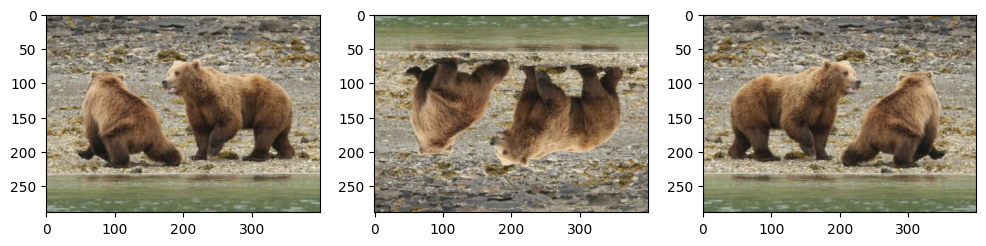

In [4]:
aug1  = A.VerticalFlip(p=1)
aug2  = A.HorizontalFlip(p=1)

show_images(imgs=[
    img, 
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

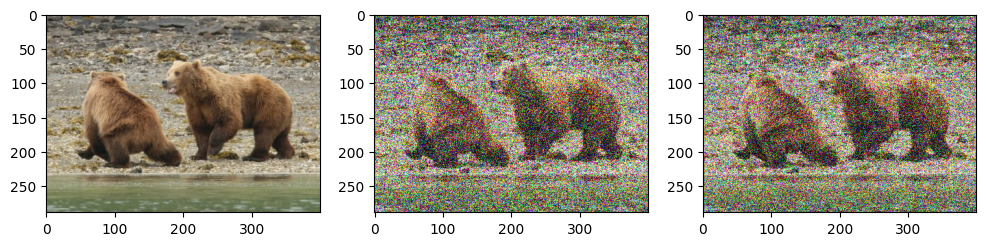

In [5]:
# Gaussian Noise (RANDOM DISTRIBUTION !!! )

'''var_limit=(min, max) defines range for variance (randomly sampled)'''
aug1 = A.GaussNoise(p=1, var_limit=10000)           # min = 10 (default), max = 10000   
aug2 = A.GaussNoise(p=1, var_limit=(1000, 10000))   # min = 1000, max = 10000 ---> should be more noisy  

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])


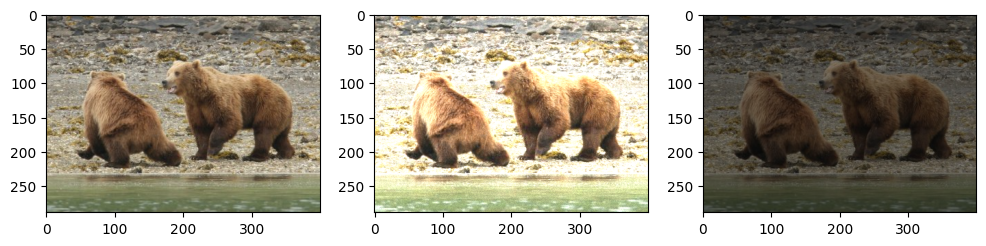

In [6]:
aug1  = A.MultiplicativeNoise(p=1, multiplier=(1.5, 1.75),  elementwise=True) # make lighter (> 1) by random factor (for each pixel individual, since elemetwise=True)
aug2  = A.MultiplicativeNoise(p=1, multiplier=0.5) # make darker (< 1) by fixed factor for all pixels

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

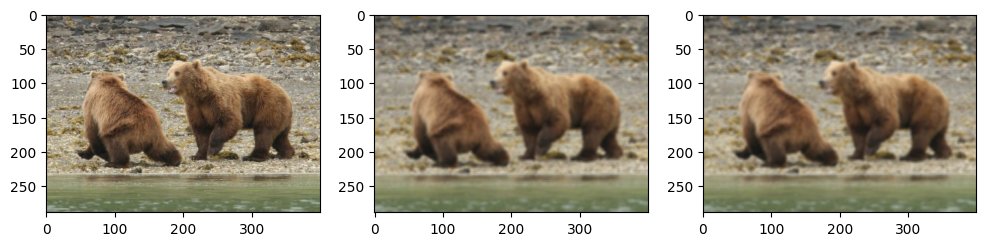

In [7]:
aug1  = A.GaussianBlur(p=1, sigma_limit=(0, 200), always_apply=True)
aug2  = A.GaussianBlur(p=1, sigma_limit=(100, 200), always_apply=True)

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

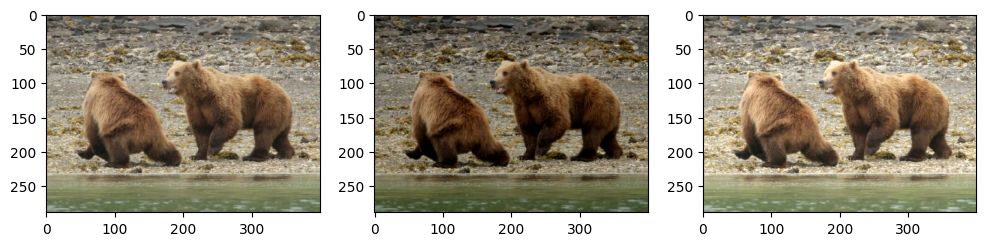

In [8]:
aug1  = A.RandomBrightnessContrast(p=1,brightness_limit=0.5, contrast_limit=0)
aug2  = A.RandomBrightnessContrast(p=1,brightness_limit=0, contrast_limit=0.75)


show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

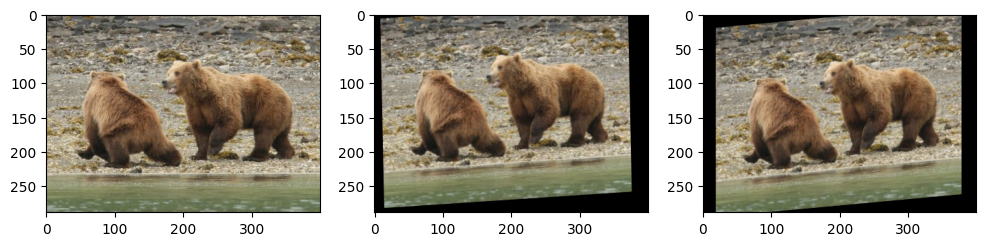

In [9]:
aug1 = A.Affine(
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=0.0,
        shear=(-5, 5),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        p=1.0
    )

aug2 = A.Affine(
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=0.0,
        shear=(-5, 5),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        p=1.0
    )

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

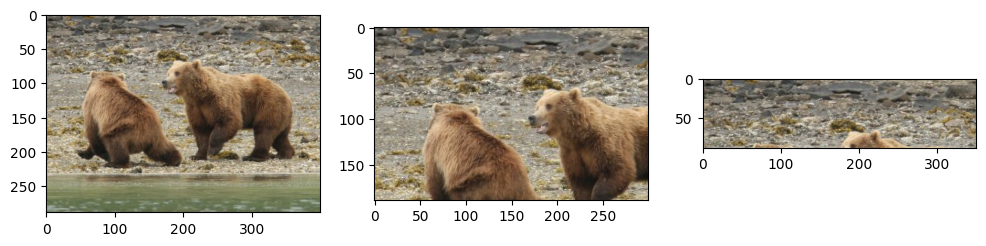

In [10]:
aug1 = A.Crop(
    x_min=0,
    y_min=0,
    x_max=img_width - 100,
    y_max=img_height - 100,
    p=1.0)

aug2 = A.Crop(
    x_min=0,
    y_min=0,
    x_max=img_width - 50,
    y_max=img_height - 200,
    p=1.0)

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

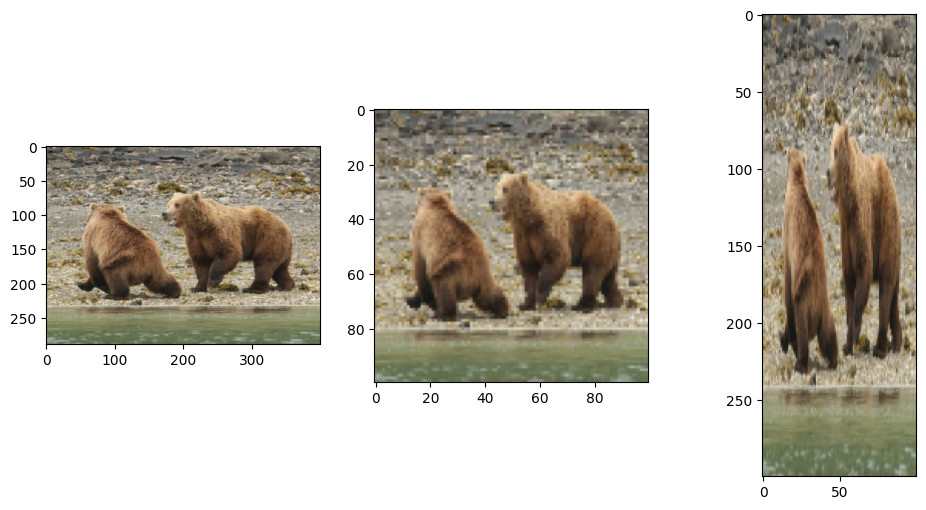

In [11]:
aug1 = A.Resize(
    height=100,
    width=100,
    p=1.0,
)

aug2 = A.Resize(
    height=300,
    width=100,
    p=1.0,
)

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

## Bee Example Image

In [12]:
import torch 
import pickle
import pathlib
import sys 
import numpy as np
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [13]:
sys.path.insert(0, '/srv/data/joeh97/github/SWP-2023-Automatic-Detection-of-Vibratory-Behavior-of-Honeybees' )

In [14]:
import config as cfg
from dataset import WDDDataset

In [15]:
def load_gt_items(path):
    '''
        pickle files contains elements in (key, value) form, like:
            KEY         VALUE
            102934      ('activating',  1.88699,  PosixPath('/mnt/curta/storage/beesbook/wdd/wdd_output_2021/cam1/2021/10/2/10/13/13/waggle.json'))

        OUTPUT
             102934    , 'activating',  1.88699,  PosixPath('/mnt/curta/storage/beesbook/wdd/wdd_output_2021/cam1/2021/10/2/10/13/13/waggle.json')
    '''
    with open(path, "rb") as f:
        r = pickle.load(f)
        items = [(key,) + v for key, v in r.items()]
    return items

def custom_collate(data):
    ''' complicated (!) pre-processing to generate `PackedSequenze` used in RNN '''
    image_seq_lens = torch.tensor([img.shape[0] for img, _ in data])
    images = [torch.tensor(img) for img, _ in data]
    images = pad_sequence(images, batch_first=True)
    label = torch.tensor([torch.tensor(y) for _, y in data])
    return images, image_seq_lens, label

In [16]:
# load images
gt_items = load_gt_items(cfg.PATH_PICKLE) 
def remap(p):
    head = pathlib.Path(cfg.PATH_IMAGES) # actual system path
    tail = p.relative_to("/mnt/curta/storage/beesbook/wdd/")  # path from pickle 
    return head.joinpath(tail) # replace path
gt_items = [tuple(item) + (remap(path),) for *item, path, in gt_items]

all_indices = np.arange(len(gt_items))
print(f"Found {len(all_indices)}  examples")
gt_items = [gt_items[i] for i in all_indices]

dataset:WDDDataset = WDDDataset(gt_items)

Found 1009  examples


Select one specfic bee image from one specific directory

In [24]:
# select img
exmpl_path = gt_items[0][3]
exmpl_path

exmpl_imgs = dataset.load_waggle_images(exmpl_path)
exmpl_img = exmpl_imgs[0]
exmpl_img

array([[-0.31556815, -0.31062186, -0.27427524, ..., -0.1594587 ,
        -0.16943106, -0.1795463 ],
       [-0.3699245 , -0.34735617, -0.2739278 , ..., -0.19878873,
        -0.2640437 , -0.30250165],
       [-0.378596  , -0.32544878, -0.24609345, ..., -0.3934474 ,
        -0.5387519 , -0.5682096 ],
       ...,
       [-0.66518724, -0.6985152 , -0.7101637 , ..., -0.8060401 ,
        -0.789029  , -0.7418793 ],
       [-0.58036435, -0.66916186, -0.7334169 , ..., -0.8145159 ,
        -0.7905677 , -0.7145615 ],
       [-0.65414965, -0.7098219 , -0.7525352 , ..., -0.7917045 ,
        -0.7451523 , -0.68696016]], dtype=float32)